In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [72]:
from google.colab import files
uploaded=files.upload()
from google.colab import files
uploaded=files.upload()
from google.colab import files
uploaded=files.upload()
from google.colab import files
uploaded=files.upload()
from google.colab import files
uploaded=files.upload()


Saving women-political-participation-index.csv to women-political-participation-index (1).csv


Saving World Happiness Report.csv to World Happiness Report (1).csv


Saving women-political-empowerment-index.csv to women-political-empowerment-index (1).csv


Saving human-development-index.csv to human-development-index (1).csv


Saving average-years-of-schooling.csv to average-years-of-schooling (1).csv


In [73]:
# Load datasets
df_participation = pd.read_csv("women-political-participation-index.csv")
df_empowerment = pd.read_csv("women-political-empowerment-index.csv")
df_happiness = pd.read_csv("World Happiness Report.csv")
df_schooling = pd.read_csv("average-years-of-schooling.csv")
df_hdi = pd.read_csv("human-development-index.csv")

print(df_participation.index)
print(df_participation.columns)
print(df_empowerment.index)
print(df_empowerment.columns)
print(df_happiness.index)
print(df_happiness.columns)
print(df_schooling.index)
print(df_schooling.columns)
print(df_hdi.index)
print(df_hdi.columns)


RangeIndex(start=0, stop=28884, step=1)
Index(['Entity', 'Code', 'Year',
       'Women's political participation index (central estimate, aggregate: average)'],
      dtype='object')
RangeIndex(start=0, stop=28540, step=1)
Index(['Entity', 'Code', 'Year',
       'Women's political empowerment index (central estimate, aggregate: average)'],
      dtype='object')
RangeIndex(start=0, stop=2199, step=1)
Index(['Country Name', 'Regional Indicator', 'Year', 'Life Ladder',
       'Log GDP Per Capita', 'Social Support',
       'Healthy Life Expectancy At Birth', 'Freedom To Make Life Choices',
       'Generosity', 'Perceptions Of Corruption', 'Positive Affect',
       'Negative Affect', 'Confidence In National Government'],
      dtype='object')
RangeIndex(start=0, stop=6557, step=1)
Index(['Entity', 'Code', 'Year', 'Average years of schooling'], dtype='object')
RangeIndex(start=0, stop=6464, step=1)
Index(['Entity', 'Code', 'Year', 'Human Development Index'], dtype='object')


In [74]:
# Cleaning Function for Standard Format
def clean_dataset(df, value_column, new_value_name, year_limit=1990):
    df = df.copy()

    # Rename value column and "Entity"/"Country Name" column
    df.rename(columns={
        value_column: new_value_name,
        "Entity": "Country",
        "Country Name": "Country"  # for World Happiness
    }, inplace=True)

    # Drop non-numeric or missing values
    df = df[pd.to_numeric(df[new_value_name], errors='coerce').notnull()]
    df[new_value_name] = pd.to_numeric(df[new_value_name])

    # Clean year
    df["Year"] = pd.to_numeric(df["Year"], errors='coerce')
    df = df[df["Year"] >= year_limit]

    # Keep only needed columns
    return df[["Country", "Year", new_value_name]]

# Apply cleaning to each dataset
df_participation_clean = clean_dataset(df_participation,
    "Women's political participation index (central estimate, aggregate: average)", "Participation_Index")

df_empowerment_clean = clean_dataset(df_empowerment,
    "Women's political empowerment index (central estimate, aggregate: average)", "Empowerment_Index")

# Clean schooling and HDI
df_schooling_clean = clean_dataset(df_schooling, "Average years of schooling", "Avg_Schooling")
df_hdi_clean = clean_dataset(df_hdi, "Human Development Index", "HDI")

# Special case: happiness dataset (multiple columns)
df_happiness.rename(columns={
    "Country Name": "Country",
    "Log GDP Per Capita": "GDP",
    "Social Support": "Support",
    "Healthy Life Expectancy At Birth": "Life_Expectancy",
    "Freedom To Make Life Choices": "Freedom",
    "Perceptions Of Corruption": "Corruption",
    "Confidence In National Government": "Gov_Trust"
}, inplace=True)

relevant_cols = ["Country", "Year", "GDP", "Support", "Life_Expectancy", "Freedom", "Corruption", "Gov_Trust"]
df_happiness_clean = df_happiness[relevant_cols].dropna()

# Convert numeric columns
num_cols = ["GDP", "Support", "Life_Expectancy", "Freedom", "Corruption", "Gov_Trust"]
df_happiness_clean[num_cols] = df_happiness_clean[num_cols].apply(pd.to_numeric, errors='coerce')
df_happiness_clean = df_happiness_clean[df_happiness_clean["Year"] >= 1900]

I know that, it is not good to use the raw data as it is. So that, to prepare the datasets for analysis, I used a standardized cleaning function and applied across all datasets. This function first unified inconsistent columns names such as "Entity" or "Country name" into a standard "Country" label and renamed the selected value column to a consistnet name. It then handled missing and non-numeric values by assigning to NaN and converted all relevant columns to numeric types. Only rows from 1990 onward were retained to focus on more recent data. For each dataset, only the essential columns were preserved. This process ensured that all datasets shared a uniform structure, enabling them to be accuretly merged and compared in merging.

In [75]:
# Step 3.1: Merge Empowerment and Participation Index
merged_df = pd.merge(df_empowerment_clean, df_participation_clean, on=["Country", "Year"], how="inner")

# Step 3.2: Merge with Schooling
merged_df = pd.merge(merged_df, df_schooling_clean, on=["Country", "Year"], how="inner")

# Step 3.3: Merge with HDI
merged_df = pd.merge(merged_df, df_hdi_clean, on=["Country", "Year"], how="inner")

# Step 3.4: Merge with Happiness dataset
merged_df = pd.merge(merged_df, df_happiness_clean, on=["Country", "Year"], how="inner")

merged_df = merged_df.drop(columns=["Entity", "Code", "Index"], errors="ignore") #Dropping datasources columns (Entity, Code, Index) to avoid data leakage.

# Step 3.5: Check final shape and preview
print(merged_df.shape)
merged_df.head()


(1734, 12)


,Country,Year,Empowerment_Index,Participation_Index,Avg_Schooling,HDI,GDP,Support,Life_Expectancy,Freedom,Corruption,Gov_Trust
0,Afghanistan,2008,0.464,0.891,1.742754,0.431,7.350416,0.450662,50.500000,0.718114,0.881686,0.612072
1,Afghanistan,2009,0.465,0.891,1.816490,0.441,7.508646,0.552308,50.799999,0.678896,0.850035,0.611545
2,Afghanistan,2010,0.478,0.902,1.890226,0.449,7.613900,0.539075,51.099998,0.600127,0.706766,0.299357
3,Afghanistan,2011,0.478,0.902,1.937043,0.457,7.581259,0.521104,51.400002,0.495901,0.731109,0.307386
4,Afghanistan,2012,0.478,0.902,1.983860,0.467,7.660506,0.520637,51.700001,0.530935,0.775620,0.435440


After cleaning the individual datasets, they were merged step-by-step into a single unified dataframe using inner joins based on matching "Country" and "Year" values. This ensured that only country-year combinations present across all datasets were retained, resulting in a final merged dataframe with 1,734 observations and 12 variables, ready for analysis.



In [76]:
merged_df.describe() #let us see the description of the data

,Year,Empowerment_Index,Participation_Index,Avg_Schooling,HDI,GDP,Support,Life_Expectancy,Freedom,Corruption,Gov_Trust
count,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000
mean,2013.734141,0.784384,0.866796,8.872697,0.722926,9.374511,0.815262,63.215603,0.750152,0.751298,0.483898
std,4.491991,0.140015,0.155480,3.435432,0.162081,1.157798,0.121753,7.202883,0.136803,0.186061,0.194884
min,2005.000000,0.046000,0.082000,0.976930,0.303000,5.526723,0.290184,6.720000,0.260069,0.035198,0.068769
25%,2010.000000,0.721000,0.814000,6.302422,0.590000,8.447404,0.750741,58.681250,0.659198,0.697029,0.329617
50%,2014.000000,0.811000,0.916000,9.553662,0.755000,9.528187,0.844275,65.070000,0.770664,0.808609,0.464834
75%,2018.000000,0.891000,0.979000,11.820883,0.863750,10.348414,0.910282,68.943748,0.859126,0.877351,0.620204
max,2021.000000,0.962000,1.000000,14.255940,0.965000,11.663788,0.987343,74.349998,0.985178,0.983276,0.993604


**Women's Political Empowerment Index**

Mean: 0.78

Range: 0.05 – 0.96

Explanation:
Most countries demonstrate moderate to high levels of political empowerment for women, with the median value at 0.81. However, the wide range of values across country-year pairs indicates that political empowerment for women has varied significantly over time and across countries.


**Women's Political Participation Index**

Mean: 0.87

Range: 0.08 – 1.00

Explanation:
Participation levels are generally high across the globe. While this suggests active inclusion of women in political processes, the gap between participation and empowerment indicates that presence alone may not translate to influence.

**Average Years of Schooling**

Mean: 8.87 years

Range: ~1 – 14.3 years

Explanation: The data reflects significant inequality in education. While some populations receive more than 14 years of schooling on average, others barely exceed 1 year. Education will be analyzed as a structural factor possibly affecting both empowerment and well-being.


**Human Development Index (HDI)**

Mean: 0.72

Range: 0.30 – 0.96

Explanation:
Most countries fall within the medium to high development range. HDI is expected to be an important control variable in later analyses, especially when modeling happiness or trust in governance.

GDP (Log Scale)

Mean: 9.37

Range: 5.53 – 11.66

Explanation:
There is a skewness toward higher-income countries, with a few wealthy nations significantly raising the global average. Since GDP influences well-being, it will be included in predictive models to isolate the effect of women's empowerment.

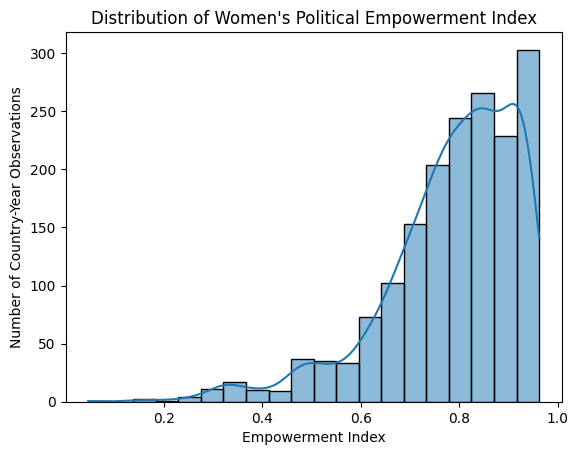

In [77]:
sns.histplot(merged_df['Empowerment_Index'], kde=True, bins=20)
plt.title("Distribution of Women's Political Empowerment Index")
plt.xlabel("Empowerment Index")
plt.ylabel("Number of Country-Year Observations")
plt.show()


This distribution highlights a global trend toward greater women's political empowerment, although there are still outlier cases with low scores. In addition to that, most values are concentrated between 0.7 and 0.95, indicating that in many countries and years, women have had relatively high political empowerment.

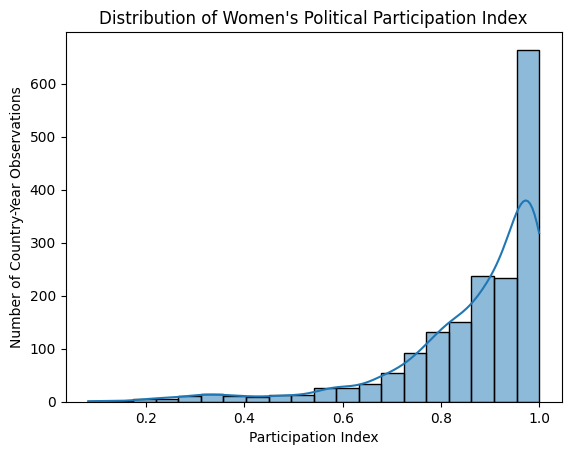

In [78]:
sns.histplot(merged_df['Participation_Index'], kde=True, bins=20)
plt.title("Distribution of Women's Political Participation Index")
plt.xlabel("Participation Index")
plt.ylabel("Number of Country-Year Observations")
plt.show()


There is a strong right skew, with the majority of values clustering between 0.85 and 1.0. This suggests that in many cases, women are formally participating in political processes. Compared to the previous histogram on Empowerment Index, this distribution is more concentrated at the top end, implying that political participation is more widespread than true political empowerment. This makes me wonder: are women being included symbolically in politics while lacking the structural support and authority to drive change? I want to explore whether this discrepancy has an impact on national well-being indicators such as trust in government or perceived corruption in later parts of my analysis.

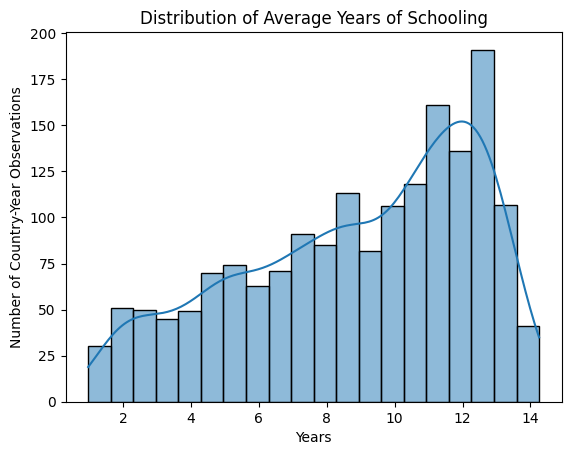

In [79]:
sns.histplot(merged_df['Avg_Schooling'], kde=True, bins=20)
plt.title("Distribution of Average Years of Schooling")
plt.xlabel("Years")
plt.ylabel("Number of Country-Year Observations")
plt.show()


While a large portion of the world seems to be achieving moderate to high educational levels, the data still reflects structural inequalities. This uneven distribution may be a key factor moderating the relationship between women's empowerment and broader societal well-being.

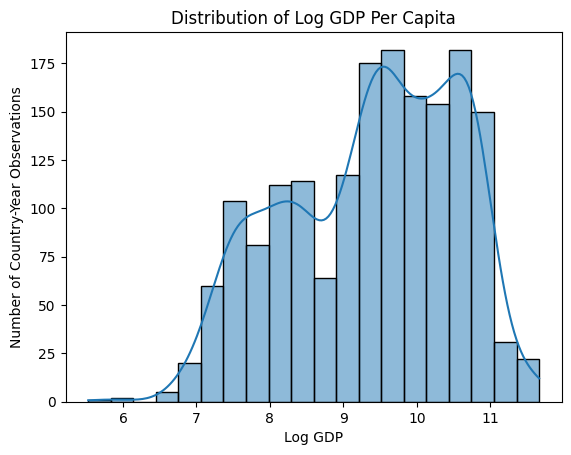

In [80]:
sns.histplot(merged_df['GDP'], kde=True, bins=20)
plt.title("Distribution of Log GDP Per Capita")
plt.xlabel("Log GDP")
plt.ylabel("Number of Country-Year Observations")
plt.show()


The wide spread confirms global differences in economic conditions. Since economic well-being often influences national happiness, it will be important to control for GDP in later analyses when examining the relationship between women’s empowerment and well-being indicators.

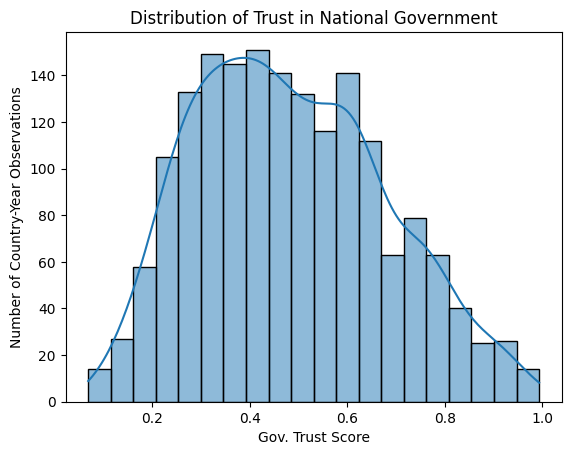

In [81]:
sns.histplot(merged_df['Gov_Trust'], kde=True, bins=20)
plt.title("Distribution of Trust in National Government")
plt.xlabel("Gov. Trust Score")
plt.ylabel("Number of Country-Year Observations")
plt.show()


The distribution is approximately bell-shaped, peaking around 0.4 to 0.5, which indicates that moderate levels of trust are the most common. Exploring how this trust level correlates with empowerment, education, and GDP will be essential in later stages of the analysis.

**The histograms reveal that while women’s political participation is widely high, true empowerment is more unevenly distributed. Education and GDP show large global disparities, and trust in government tends to be moderate or low in most observations. These patterns suggest that national well-being is shaped by both structural and political factors, which will be explored further in the next steps.**

In [82]:
merged_df["Emp_Group"] = pd.qcut(merged_df["Empowerment_Index"], q=2, labels=["Low", "High"])
# Categorize observations into two groups based on Empowerment Index.
# This will allow comparison of variables like trust or schooling across empowerment levels.

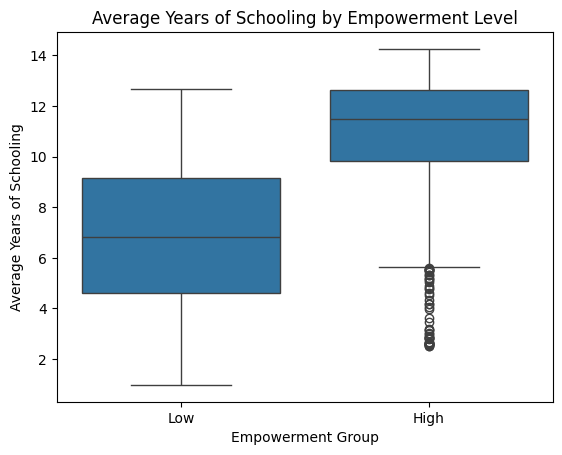

In [83]:
sns.boxplot(data=merged_df, x="Emp_Group", y="Avg_Schooling")
plt.title("Average Years of Schooling by Empowerment Level")
plt.xlabel("Empowerment Group")
plt.ylabel("Average Years of Schooling")
plt.show()


This supports the idea that education plays a foundational role in fostering women’s political empowerment. Countries with higher schooling levels are more likely to empower women in meaningful political roles, reinforcing the link between education and women's empowerment level.

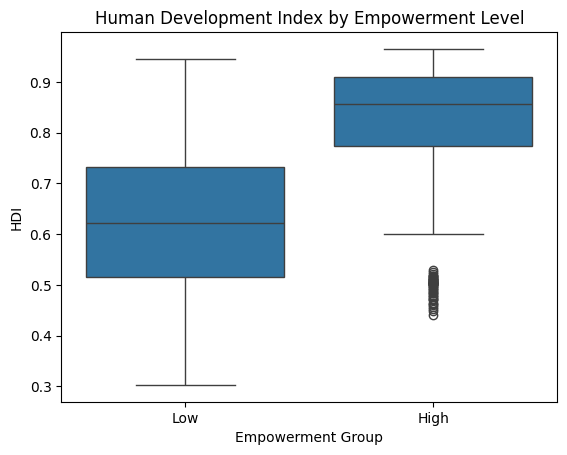

In [84]:
sns.boxplot(data=merged_df, x="Emp_Group", y="HDI")
plt.title("Human Development Index by Empowerment Level")
plt.xlabel("Empowerment Group")
plt.ylabel("HDI")
plt.show()


This bar chart confirms a strong positive relationship between women’s political empowerment and national development. Countries that politically empower women tend to perform significantly better on core human development indicators, supporting the idea that empowering women contributes to overall well-being.

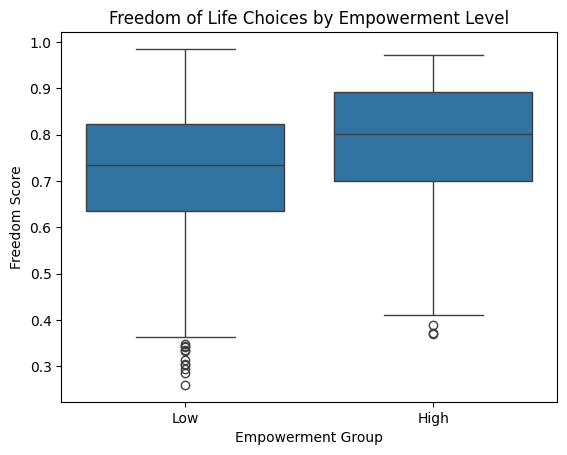

In [85]:
sns.boxplot(data=merged_df, x="Emp_Group", y="Freedom")
plt.title("Freedom of Life Choices by Empowerment Level")
plt.xlabel("Empowerment Group")
plt.ylabel("Freedom Score")
plt.show()


This visual suggests that higher political empowerment of women is positively associated with perceived personal freedom in a society. The high empowerment group has a higher median freedom score, centered around 0.85, and most values lie within a narrower, upper range.

**The boxplots reveal consistent patterns supporting the idea that higher women's political empowerment is associated with better national well-being. Countries in the high empowerment group tend to have higher median values for education, human development, and freedom to make life choices.**

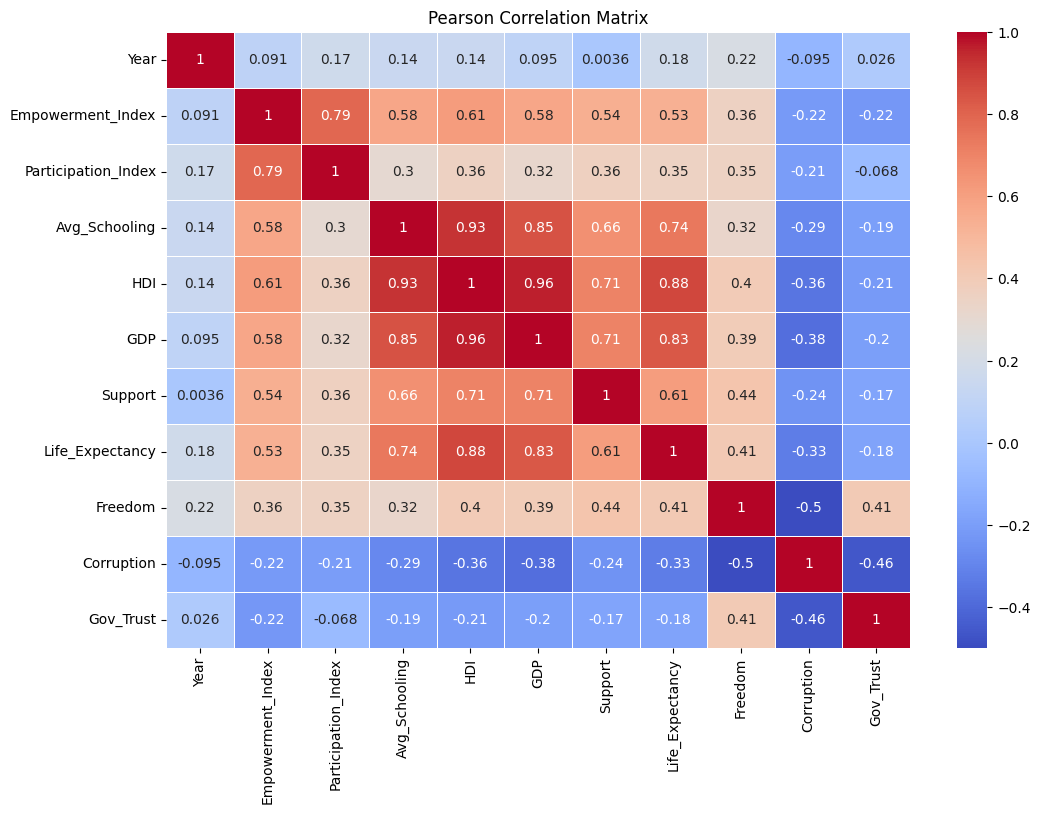

In [86]:
# Create a correlation matrix for all numeric columns
corr_matrix = merged_df.corr(numeric_only=True)

# Plot it
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Pearson Correlation Matrix")
plt.show()


**Correlation Analysis Summary**

The pearson correlation matrix highlights several key relationships between women's political empowerment and national well-being indicators:

1- Empowerment has strong positive correlations with:



*   Participation Index (0.79)
*   Average Years of Schooling (0.58)

*   HDI (0.61) and GDP (0.58)


2- Empowerment has moderate positive correlations with:



*   Life Expectancy (0.53)

*   Freedom (0.36)

3- Empowerment has moderate negative correlations with:



*   Corruption (-0.22)

*   Government Trust (-0.22)





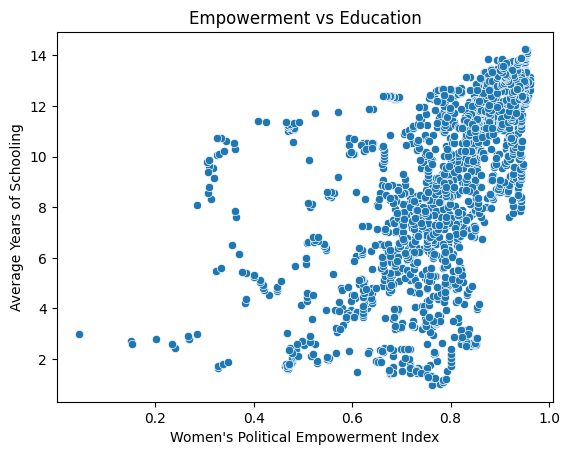

In [87]:
sns.scatterplot(data=merged_df, x="Empowerment_Index", y="Avg_Schooling")
plt.title("Empowerment vs Education")
plt.xlabel("Women's Political Empowerment Index")
plt.ylabel("Average Years of Schooling")
plt.show()


Countries with higher women's empowerment levels tend to have significantly higher average years of schooling.This supports the idea that education is not just an outcome of development, but also a foundation for political inclusion and long-term women's empowerment.

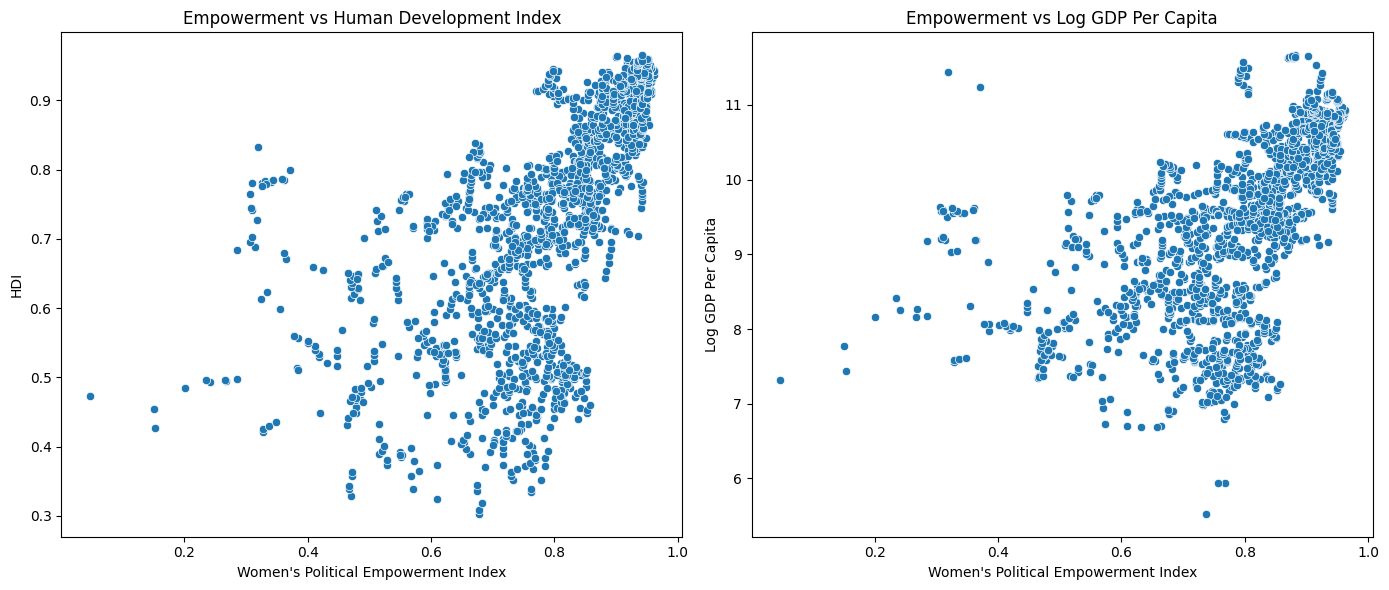

In [88]:
# Set figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plot 1: Empowerment vs HDI
sns.scatterplot(ax=axes[0], data=merged_df, x="Empowerment_Index", y="HDI")
axes[0].set_title("Empowerment vs Human Development Index")
axes[0].set_xlabel("Women's Political Empowerment Index")
axes[0].set_ylabel("HDI")

# Plot 2: Empowerment vs GDP
sns.scatterplot(ax=axes[1], data=merged_df, x="Empowerment_Index", y="GDP")
axes[1].set_title("Empowerment vs Log GDP Per Capita")
axes[1].set_xlabel("Women's Political Empowerment Index")
axes[1].set_ylabel("Log GDP Per Capita")

plt.tight_layout()
plt.show()

Both HDI and GDP are strongly and positively correlated with empowerment. The scatter plots reveal that countries with more empowered women tend to be more economically prosperous and socially developed.

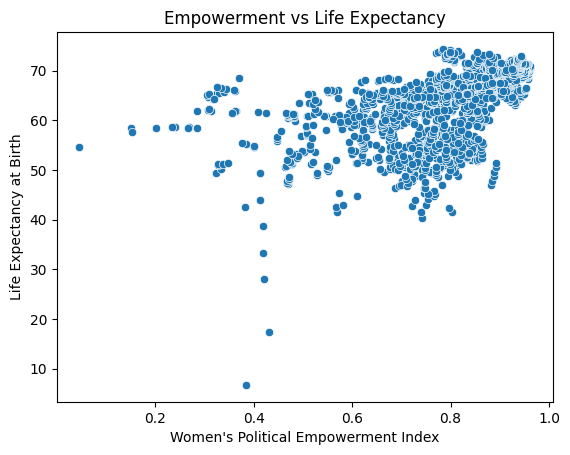

In [89]:
sns.scatterplot(data=merged_df, x="Empowerment_Index", y="Life_Expectancy")
plt.title("Empowerment vs Life Expectancy")
plt.xlabel("Women's Political Empowerment Index")
plt.ylabel("Life Expectancy at Birth")
plt.show()


Life expectancy increases with women's empowerment, which may reflect better access to healthcare, stability, and long-term policy focus in more inclusive societies.

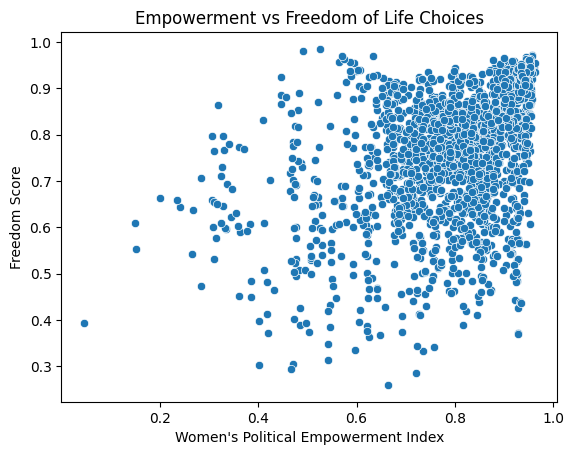

In [90]:
sns.scatterplot(data=merged_df, x="Empowerment_Index", y="Freedom")
plt.title("Empowerment vs Freedom of Life Choices")
plt.xlabel("Women's Political Empowerment Index")
plt.ylabel("Freedom Score")
plt.show()


While the relationship is not as strong as the other indicators, there's a positive trend which suggests that political empowerment may also influence perceived personal freedom.

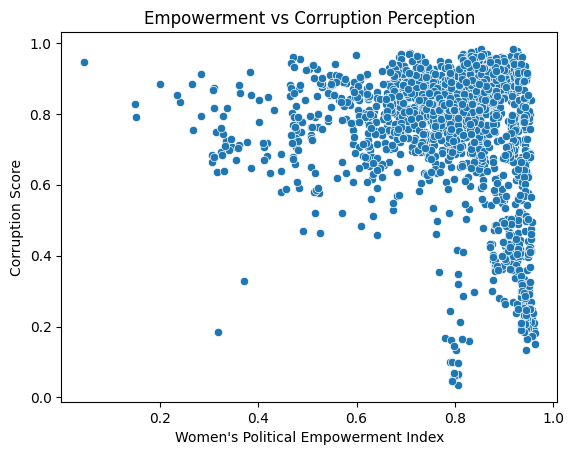

In [91]:
sns.scatterplot(data=merged_df, x="Empowerment_Index", y="Corruption")
plt.title("Empowerment vs Corruption Perception")
plt.xlabel("Women's Political Empowerment Index")
plt.ylabel("Corruption Score")
plt.show()


The moderate negative trend indicates that more women's empowered countries tend to report lower levels of perceived corruption showing that as women's empowerment increases, perceived corruption tends to decrease, pointing to a healthier governance environment.



**Correlation analysis and scatter plots reveal that women's political empowerment is positively correlated with key development indicators such as education, HDI, and GDP. The visualizations show upward trends, confirming that countries with higher levels of women's empowerment tend to be more developed, educated, and economically stable. These relationships provide strong statistical and visual support for the idea that empowering women in politics contributes to broader national well-being.**


----------------------------------------------------------



**Hypotheses Testings**

1- For education:

H₀ (null hypothesis):
There is no difference in average schooling between high and low empowerment groups.

H₁ (alternative hypothesis):
There is a significant difference in average schooling between the two groups.


In [92]:
from scipy.stats import ttest_ind

# Split data into high and low empowerment groups
low_group = merged_df[merged_df["Emp_Group"] == "Low"]["Avg_Schooling"]
high_group = merged_df[merged_df["Emp_Group"] == "High"]["Avg_Schooling"]

# Perform t-test
t_stat, p_val = ttest_ind(low_group, high_group, equal_var=False)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.5f}")


T-statistic: -30.285
P-value: 0.00000


An independent samples t-test was conducted to determine whether the average years of schooling differs significantly between countries with low and high levels of women's political empowerment. The test yielded a t-statistic of -30.285 and a p-value < 0.005, which leds us to reject the null hypothesis and say there is a significant difference in average schooling between two groups.

-------------------------------------

2- for HDI


*   H₀ (Null): There is no difference in HDI between high and low empowerment groups.
*   H₁ (Alt): There is a significant difference in HDI between the two groups.




In [93]:
# Extract HDI values
low_group = merged_df[merged_df["Emp_Group"] == "Low"]["HDI"]
high_group = merged_df[merged_df["Emp_Group"] == "High"]["HDI"]

# Sample means
mean_low = low_group.mean()
mean_high = high_group.mean()

# Standard deviation from full dataset (shared earlier)
std_pop = 0.16208  # population standard deviation for HDI that I previously found

# Sample sizes
n_low = len(low_group)
n_high = len(high_group)

# Z-statistic (for difference in means)
z = (mean_high - mean_low) / np.sqrt((std_pop**2 / n_low) + (std_pop**2 / n_high))

# Two-tailed test p-value
p_val = 2 * (1 - stats.norm.cdf(abs(z)))

print(f"Z-statistic: {z:.3f}")
print(f"P-value: {p_val:.5f}")


Z-statistic: 26.786
P-value: 0.00000


The result is highly statistically significant, allowing us to confidently reject the null hypothesis. Since the high empowerment group has a higher average HDI, we conclude that countries with greater political empowerment for women also tend to have significantly higher levels of human development.

# **Machiene Learning Analysis**

In [94]:
from sklearn.preprocessing import MinMaxScaler

# Define the columns involved in the composite well-being score
wellbeing_columns = ['HDI', 'Life_Expectancy', 'Freedom', 'Support', 'Gov_Trust', 'Corruption']

# Initialize scaler
scaler = MinMaxScaler()

# Apply scaler to selected columns and create a new DataFrame
normalized_data = pd.DataFrame(
    scaler.fit_transform(merged_df[wellbeing_columns]),
    columns=[f'norm_{col}' for col in wellbeing_columns]
)

# Concatenate normalized columns back to the original DataFrame
merged_df = pd.concat([merged_df, normalized_data], axis=1)


### Composite Well-Being Score Construction

To model national well-being in a multidimensional way, I followed the approach inspired by Martinez-Martin’s *Composite Global Well-Being Index (CGWBI)* (2016), which emphasizes the integration of both objective and subjective indicators of development. Based on this framework, I constructed a composite score using six variables: Human Development Index (HDI), Life Expectancy, Freedom, Social Support, Government Trust, and Corruption.

These indicators were chosen to reflect a holistic view of human well-being, going beyond economic output. All variables were normalized using Min-Max scaling, and the Corruption variable was inverted so that higher scores consistently represent better outcomes across all features. This composite score serves as the target for the machine learning models in the following analysis.

**Reference:**  
Martinez-Martin, N. (2016). *The Composite Global Well-Being Index (CGWBI): A New Multi-Dimensional Measure of Human Development*. [ResearchGate](https://www.researchgate.net/publication/282435182_The_Composite_Global_Well-Being_Index_CGWBI_A_New_Multi-Dimensional_Measure_of_Human_Development)


In [95]:
# Invert the normalized corruption score
merged_df['inv_norm_Corruption'] = 1 - merged_df['norm_Corruption']


The normalized corruption score was inverted (`1 - norm_Corruption`) so that higher values indicate lower corruption. This keeps the direction consistent with other features in the composite well-being score, where higher values always represent better conditions.

In [96]:
# Define the final set of indicators to include
composite_components = [
    'norm_HDI',
    'norm_Life_Expectancy',
    'norm_Freedom',
    'norm_Support',
    'norm_Gov_Trust',
    'inv_norm_Corruption'
]

# Compute the composite score
merged_df['WellBeing_Score'] = merged_df[composite_components].mean(axis=1)


The final composite score was calculated by taking the average of six normalized indicators: HDI, Life Expectancy, Freedom, Support, Government Trust, and the inverted Corruption score. This score represents an overall measure of national well-being, where higher values indicate better outcomes.

In [97]:
# Define input features
feature_cols = [
    'Empowerment_Index',
    'Participation_Index',
    'Avg_Schooling',
    'GDP'
]

X = merged_df[feature_cols]
y = merged_df['WellBeing_Score']


The model uses four input features to predict the composite well-being score: Empowerment_Index and Participation_Index (representing women’s political leadership), along with Avg_Schooling and GDP (as structural development controls). These variables form the input matrix `X`, while the target variable `y` is the previously constructed WellBeing_Score.

### Linear Regression: Predicting Well-Being from Women’s Leadership and Structural Factors

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred = lr_model.predict(X_test)

# Evaluate
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


R² Score: 0.5937361991352637
MSE: 0.006372116313881097


A multiple linear regression model was trained to predict the composite well-being score using four features: Empowerment_Index, Participation_Index, Avg_Schooling, and GDP. The dataset was split into training and test sets (80/20), and the model’s performance was evaluated on the test set using the R² score and Mean Squared Error (MSE).

The resulting R² score of approximately 0.59 which indicates that the model explains about 59% of the variance in national well-being. This suggests that women's leadership, when combined with structural factors like education and economic performance, has a meaningful association with overall well-being.


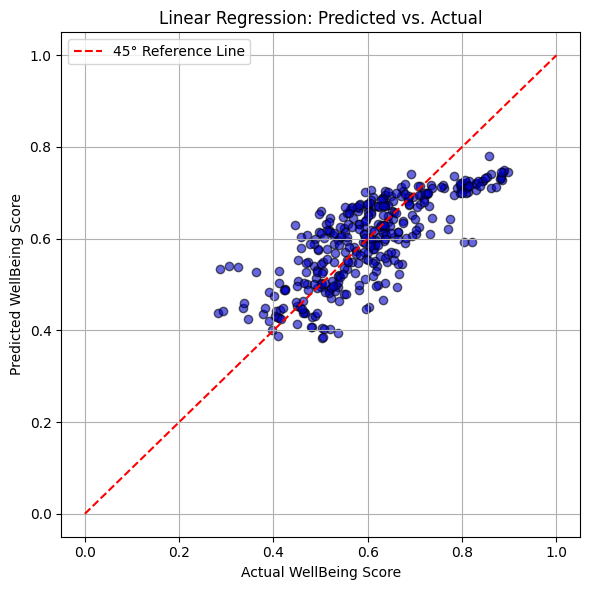

In [99]:
# Scatter plot for Linear Regression
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='mediumblue', edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--', label='45° Reference Line')  # ideal prediction
plt.xlabel('Actual WellBeing Score')
plt.ylabel('Predicted WellBeing Score')
plt.title('Linear Regression: Predicted vs. Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


This scatter plot shows how well the Linear Regression model predicts the Composite Well-Being Score. Points closer to the red 45° line represent better predictions. While there is a clear positive trend, the spread indicates the model has limited accuracy and may miss some complexity in the data.

### Random Forest: Modeling Nonlinear Relationships in Well-Being Prediction

In [100]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
from sklearn.metrics import r2_score, mean_squared_error

print("Random Forest R² Score:", r2_score(y_test, y_pred_rf))
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))


Random Forest R² Score: 0.8458204645594762
Random Forest MSE: 0.002418256145282982


To capture potential nonlinear relationships between features and well-being, a Random Forest Regressor was trained using the same four predictors: Empowerment_Index, Participation_Index, Avg_Schooling, and GDP. Random Forests, being ensemble models based on decision trees, are well-suited for modeling complex interactions without requiring explicit feature transformations.

The model achieved a high R² score of approximately 0.85, significantly outperforming the linear regression model. This indicates that 85% of the variance in the well-being score can be explained by the selected features, suggesting a strong predictive relationship, especially when allowing for nonlinear effects.


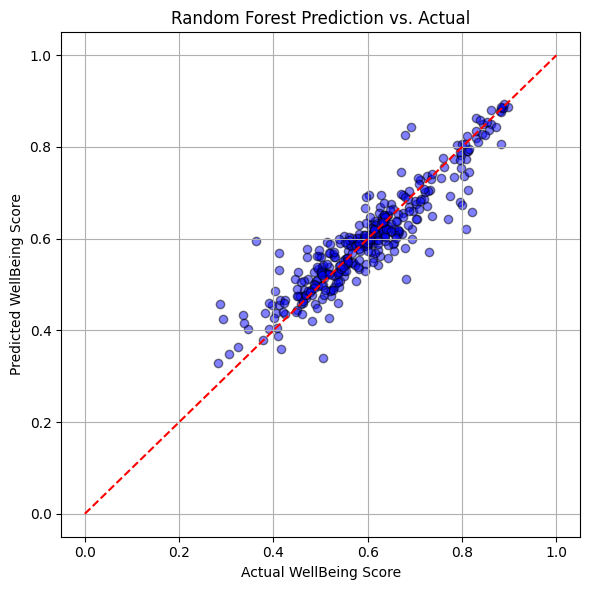

In [102]:

# Create the scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='blue', edgecolor='k')
plt.plot([0, 1], [0, 1], '--', color='red')  # 45-degree reference line
plt.xlabel('Actual WellBeing Score')
plt.ylabel('Predicted WellBeing Score')
plt.title('Random Forest Prediction vs. Actual')
plt.grid(True)
plt.tight_layout()
plt.show()


This scatter plot compares the Random Forest model’s predicted well-being scores to the actual values from the test set. The red dashed line represents the ideal 45-degree line where predicted values would perfectly match actual scores. Most data points cluster closely around this line, indicating a strong predictive performance. This visual reinforces the model’s high R² score and supports the conclusion that women’s leadership, combined with structural indicators, can meaningfully predict national well-being.


### Decision Tree Method

In [103]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Initialize the model
dt_model = DecisionTreeRegressor(random_state=42)


In [104]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [105]:
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [106]:
y_pred_dt = dt_model.predict(X_test)

print("Decision Tree R² Score:", r2_score(y_test, y_pred_dt))
print("Decision Tree MSE:", mean_squared_error(y_test, y_pred_dt))


Decision Tree R² Score: 0.765243917518694
Decision Tree MSE: 0.003682073223796764


This code evaluates the performance of the Decision Tree Regressor by predicting the well-being scores for the test set and calculating the R² Score and Mean Squared Error (MSE). An R² Score of approximately 0.77 indicates that the model explains a substantial portion of the variance in well-being scores, while the low MSE confirms good prediction accuracy.

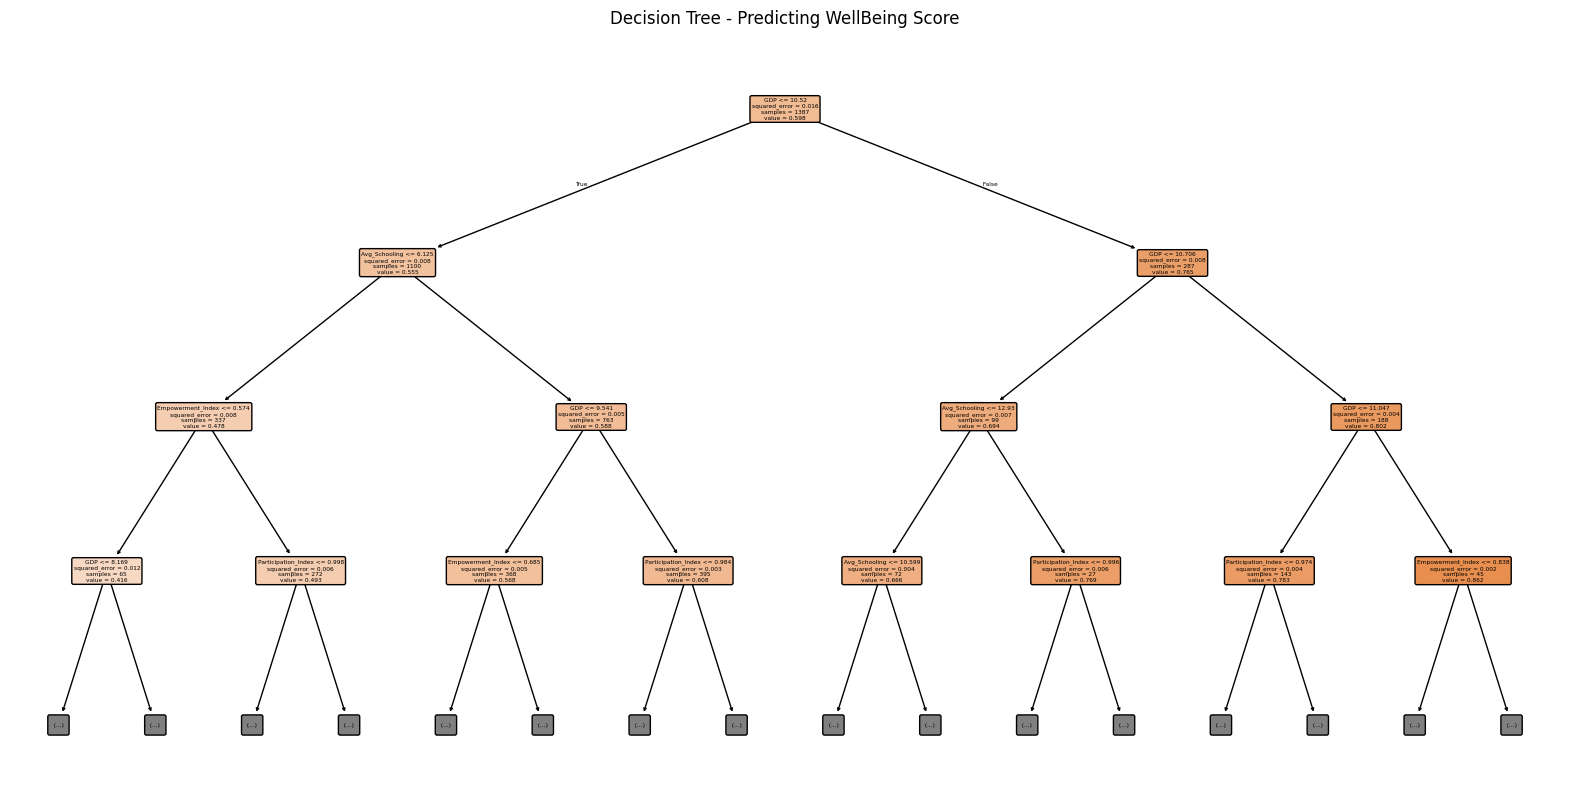

In [107]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X.columns, filled=True, rounded=True, max_depth=3)
plt.title("Decision Tree - Predicting WellBeing Score")
plt.show()


This visualization displays the structure of the trained Decision Tree Regressor used to predict the composite Well-Being Score. Each node represents a decision based on a feature (e.g., GDP or Avg_Schooling), and branches split the data accordingly. The tree helps interpret how different variables and thresholds contribute to predicting well-being, with the depth limited to 3 for clarity.

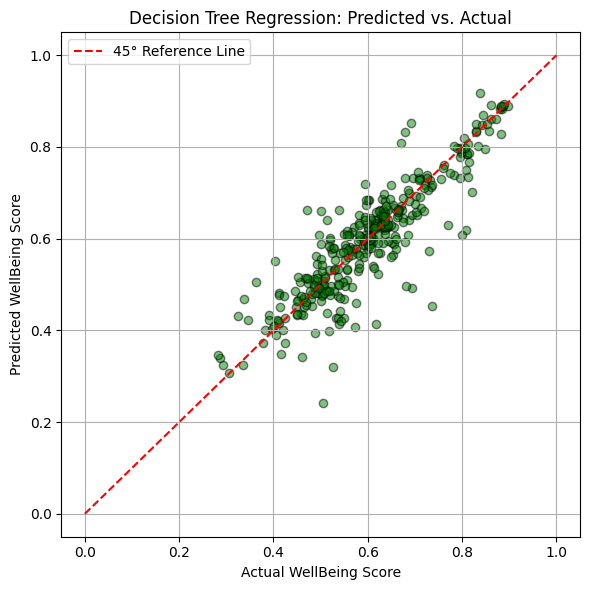

In [108]:
# Create scatter plot: Actual vs Predicted for Decision Tree
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_dt, alpha=0.5, color='green', edgecolor='k')
plt.plot([0, 1], [0, 1], '--', color='red', label='45° Reference Line')
plt.xlabel('Actual WellBeing Score')
plt.ylabel('Predicted WellBeing Score')
plt.title('Decision Tree Regression: Predicted vs. Actual')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

This scatter plot shows how well the Decision Tree Regressor predicts the composite Well-Being Score. Each point compares actual vs. predicted values, and the red dashed line represents perfect predictions. Most points are close to the line, indicating decent performance, but with more variance than the Random Forest model.

###Comparing Well-Being Across Levels of Women’s Empowerment

In [109]:
# Create categorical bins for Empowerment_Index
merged_df['Emp_Group'] = pd.cut(
    merged_df['Empowerment_Index'],
    bins=[0, 0.6, 0.8, 1.0],
    labels=['Low', 'Medium', 'High']
)


To examine how well-being or freedom varies with different levels of women’s empowerment, the continuous Empowerment_Index was categorized into three ordinal groups: Low (≤ 0.6), Medium (0.6–0.8), and High (> 0.8). This transformation makes it easier to compare well-being outcomes across clearly defined empowerment levels.

<ipython-input-110-5481a982a7b4>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Emp_Group', y='WellBeing_Score', data=merged_df, palette='pastel')


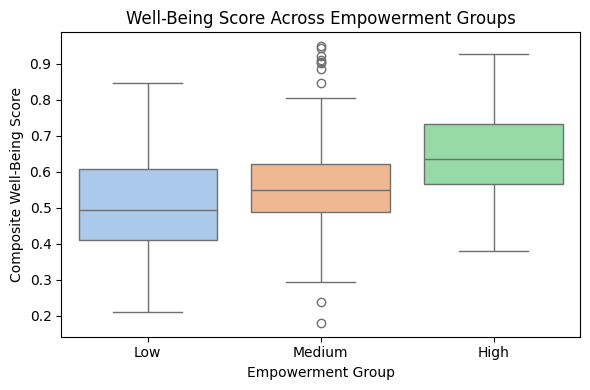

In [110]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Emp_Group', y='WellBeing_Score', data=merged_df, palette='pastel')
plt.title('Well-Being Score Across Empowerment Groups')
plt.xlabel('Empowerment Group')
plt.ylabel('Composite Well-Being Score')
plt.tight_layout()
plt.show()


This boxplot visualizes how the Composite Well-Being Score varies across Low, Medium, and High empowerment groups.

* As empowerment increases, both the median and distribution of well-being rise.

* The boxplot supports the statistical findings: higher empowerment aligns with greater national well-being.

The visual distribution mirrors the t-test results: higher empowerment groups enjoy visibly better well-being.

In [111]:
low_group = merged_df[merged_df['Emp_Group'] == 'Low']['WellBeing_Score']
high_group = merged_df[merged_df['Emp_Group'] == 'High']['WellBeing_Score']

t_stat, p_val = ttest_ind(high_group, low_group, nan_policy='omit')
print("T-statistic:", t_stat)
print("P-value:", p_val)

T-statistic: 14.892728179158322
P-value: 9.667184861315044e-46


This performs an independent samples t-test to determine whether there's a statistically significant difference in Well-Being Score between the countries with Low and High levels of women's empowerment.

The T-statistic of ~14.89 indicates a large difference between means.

The p-value (< 0.0001) is far below 0.05, confirming the difference is statistically significant.

So, we can say that countries with higher women's empowerment scores tend to have significantly higher well-being scores.

###**Conclusion**
Through this machine learning analysis, I confirmed that women’s political empowerment and participation are important contributors to national well-being. Across all models, including Linear Regression, Random Forest, and Decision Tree, leadership indicators consistently played a meaningful role in predicting composite well-being.

The statistical tests and group comparisons further supported this finding, showing significantly higher well-being and freedom scores in countries with higher levels of women’s political empowerment. These results reinforce the central idea of my project: political empowerment of women is not only a measure of gender equality but a key factor in building happier, healthier societies.

